<a target="_blank" href="https://colab.research.google.com/github/wri/cities-heat-workspace/blob/dev-vinamra/notebooks/lst/thermalcomfort_statistics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#!pip install rioxarray

In [3]:
import os, warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import xarray as xr
import rioxarray as rio
import geopandas as gpd
from osgeo import gdal

#from xrspatial import zonal_stats
import rasterio

import matplotlib.pyplot as plt

In [3]:
#folder = '../../data/ThermalComfort/' #preferred folder path
#os.chdir(folder)

# Functions

In [4]:
def get_crs(file_path, data_type = 'vector'):

    '''
    file_path: Path to geojson or TIFF of the file for which CRS information is required.
    data_type: Type of data. It can be either 'vector' or 'raster'. default is 'vector'.
    '''

    if data_type == 'vector':
        gdf = gpd.read_file(file_path)
        crs = str(gdf.crs).upper()
        gdf = None
        return crs

    elif data_type == 'raster':
        ds = rasterio.open(file_path)
        crs = str(ds.crs)
        ds = None
        return crs

    else: print("Input a valid 'data_type'. Either 'vector' or 'raster'. Default is 'vector'.")

In [5]:
def change_crs(file_path, crs, data_type = 'vector'):

    '''
    file_path: Path to geojson or TIFF for which CRS is to be changed.
    crs: CRS in which file is to be changed.
    data_type: Type of data. It can be either 'vector' or 'raster'. default is 'vector'.
    '''

    if data_type == 'vector':

        if crs != get_crs(file_path, data_type = 'vector'):
            gdf = gpd.read_file(file_path)
            gdf = gdf.to_crs(crs)
        else:
            gdf = gpd.read_file(file_path)

        return gdf

    elif data_type == 'raster':

        if f"temp_change_crs_{file_path.split('/')[-1].split('.')[0]}" in os.listdir(): os.remove(f"temp_change_crs_{file_path.split('/')[-1].split('.')[0]}")

        if crs != get_crs(file_path, data_type = 'raster'):
            reproject = gdal.Warp(f"temp_change_crs_{file_path.split('/')[-1].split('.')[0]}.tif", file_path, dstSRS = crs)
            reproject = None
            ds = xr.open_dataset(f"temp_change_crs_{file_path.split('/')[-1].split('.')[0]}.tif", engine='rasterio')
        else:
            pass

    else: print("Input a valid 'data_type'. Either 'vector' or 'raster'. Default is 'vector'.")

In [6]:
def get_raster_res(raster_path):

    '''
    raster_path: Path to TIFF for which resolution is required.
    '''

    ds = gdal.Open(raster_path)
    _, xres, _, _, _, yres  = ds.GetGeoTransform()
    ds = None

    return (yres, xres)

In [7]:
def get_raster_shape(raster_path):

    '''
    raster_path: Path to TIFF for which shape is required.
    '''

    ds = gdal.Open(raster_path)
    ds_shape  = ds.ReadAsArray().shape
    ds = None

    return ds_shape

In [8]:
def resmple_raster(raster_path, base_raster_path):

    '''
    raster_path: Path to TIFF that is to be resampled.
    base_raster: Path to TIFF based on which the first raster will be resampled.
    '''

    if f'temp_resmple_raster_{raster_path}' in os.listdir(): os.remove(f'temp_resmple_raster_{raster_path}')

    # Open the two datasets
    ras_ds = rio.open_rasterio(raster_path)
    base_ds = rio.open_rasterio(base_raster_path)

    # Define the resampling parameters
    new_width = base_ds.rio.width
    new_height = base_ds.rio.height
    resampling = rasterio.enums.Resampling.nearest

    # Resample the first dataset to the new dimensions and resampling method
    ras_resampled = ras_ds.rio.reproject(
        base_ds.rio.crs,
        shape=(new_height, new_width),
        resampling = resampling,
        nodata = -999
    )

    ras_resampled = ras_resampled.where(ras_resampled != -999, np.nan)

    ras_resampled.rio.to_raster(f"temp_resmple_raster_{raster_path.split('/')[-1].split('.')[0]}.tif")

    ras_resampled = None

In [9]:
def make_netcdf(file_path_list, base_raster_path):

    '''
    file_path_list: List of paths of GeoJSON(s) and TIFF(s) from which a NetCDF is to be made for local storage.
    base_raster_path: Path to the TIFF whose CRS, resolution and shape will be followed for files in the list.
    '''

    if base_raster_path in file_path_list: file_path_list.remove(base_raster_path)

    base_ds = xr.open_dataset(base_raster_path, engine='rasterio')

    crs = get_crs(base_raster_path, data_type='raster')

    for file in file_path_list:
        print(file)

        if file.endswith('.geojson'):

            gdf = change_crs(file, crs, data_type='vector')

            gdf = gdf.reset_index()[['geometry', 'index']]
            gdf['index'] = gdf['index'] + 1
            geom = gdf[['geometry', 'index']].values.tolist()

            gdf_ds = rasterio.features.rasterize(geom, out_shape=[base_ds.dims['y'],base_ds.dims['x']], transform=base_ds.rio.transform())

            #ds = base_ds.squeeze().copy()

            base_ds[file.split('/')[-1].split('.')[0]] = (('y', 'x'), gdf_ds)


        elif file.endswith('.tif'):

            if crs == get_crs(file, data_type='raster'):

                if (get_raster_res(base_raster_path) == get_raster_res(file)) and (get_raster_shape(base_raster_path) != get_raster_shape(file)):

                    resample = resmple_raster(file, base_raster_path)
                    resample = None

                    ds = xr.open_dataset(f'temp_resmple_raster_{file}', engine='rasterio')

                else: ds = xr.open_dataset(file, engine='rasterio')

            else:

                reproject = change_crs(file, crs, data_type='raster')
                reproject = None

                if (get_raster_res(base_raster_path) != get_raster_res(f"temp_change_crs_{file.split('/')[-1].split('.')[0]}.tif")) and (get_raster_shape(base_raster_path) != get_raster_shape(f"temp_change_crs_{file.split('/')[-1].split('.')[0]}.tif")):

                    resample = resmple_raster(f"temp_change_crs_{file.split('/')[-1].split('.')[0]}.tif", base_raster_path)
                    resample = None

                    ds = xr.open_dataset(f"temp_resmple_raster_temp_change_crs_{file.split('/')[-1].split('.')[0]}.tif")

                else:

                    ds = xr.open_dataset(file)

            base_ds[file.split('/')[-1].split('.')[0]] = (('y', 'x'), np.array(ds['band_data'])[0])

            # we want to replace the above line with the following. but currently unbale to do this because the resampled raster doesnt overlay perfectly
            #base_ds[file.replace('.tif','')] = ds['band_data']

            ds = None

    base_ds[base_raster_path.split('/')[-1].split('.')[0]] = (('y', 'x'), np.array(base_ds['band_data'][0]))
    base_ds['constant'] = (('y', 'x'), np.array(base_ds['band_data'][0])*0)

    return base_ds

In [10]:
def calculate_zonalstats(zones_band, value_band, xr_ds = None, netcdf_path = None):

    '''
    zones_band: Name of the NetCDF band taken as zone.
    value_band: Name of the NetCDF band taken as values that are to be summarised.
    xr_ds: xarray dataset from which the zonal statistics are to be calculated.
    netcdf_path: Path to NetCDF that is storing the data from all variables.

    Both xr_ds and netcdf_path cannot be None at the same time.

    To get summary statistics of band, input zones_band as 'constant'.
    '''

    if netcdf_path == None:
        ds = xr_ds
    elif xr_ds == None:
        ds = xr.open_dataset(netcdf_path, engine='rasterio')
    df = pd.DataFrame({'zones' : np.array(ds[zones_band]).ravel(), 'values' : np.array(ds[value_band]).ravel()})
    zs = df.groupby('zones').describe()

    return zs

# Making NetCDF

In [11]:
# input of s3 links instead. currently I don;t have the access to could not do that
nc = make_netcdf(['https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_aoi.geojson',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_parks.geojson',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_parkdissolved.geojson',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_canopyheight.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_landcover.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_shadow.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_skyview.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_tmrt.tif'],
                 'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_tmrt.tif')
nc.to_netcdf('vector_zone.nc')
nc = None

https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_aoi.geojson
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_parks.geojson
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_parkdissolved.geojson
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_canopyheight.tif
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_landcover.tif
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_shadow.tif
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_skyview.tif


In [12]:
# input list of s3 links instead. currently I don;t have the access to could not do that
nc = make_netcdf(['https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_canopyheight.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_shadow.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_skyview.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_tmrt.tif',
                  'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/processed/citycentre_landcover.tif'],
                 'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/processed/citycentre_landcover.tif')
nc.to_netcdf('raster_zone.nc')
nc = None

https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_canopyheight.tif
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_shadow.tif
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_skyview.tif
https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/raw/analysis/capetown_tmrt.tif


In [13]:
# input list of s3 links instead. currently I don;t have the access to could not do that
nc = make_netcdf(['https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/processed/capetown_lst.tif'], 'https://wri-cities-heat.s3.amazonaws.com/ZAF-Cape_town/processed/capetown_lst.tif')
nc.to_netcdf('capetown_lst.nc')
nc = None

# Maps, Histograms and Summary Statistics

In [14]:
vec_ds = xr.open_dataset('vector_zone.nc') # the netcdf
vec_df = vec_ds.to_dataframe() # convert to dataframe

ras_ds = xr.open_dataset('raster_zone.nc') # the netcdf
ras_df = ras_ds.to_dataframe() # convert to dataframe

lst_ds = xr.open_dataset('capetown_lst.nc') # the netcdf
lst_df = lst_ds.to_dataframe() # convert to dataframe

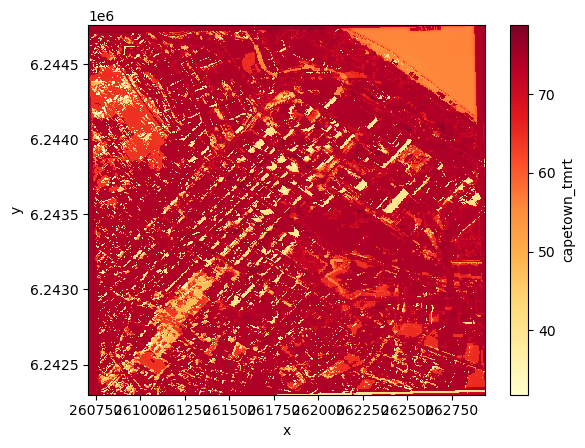

In [15]:
vec_ds['capetown_tmrt'].plot(cmap = "YlOrRd") # add the band name to be visualised

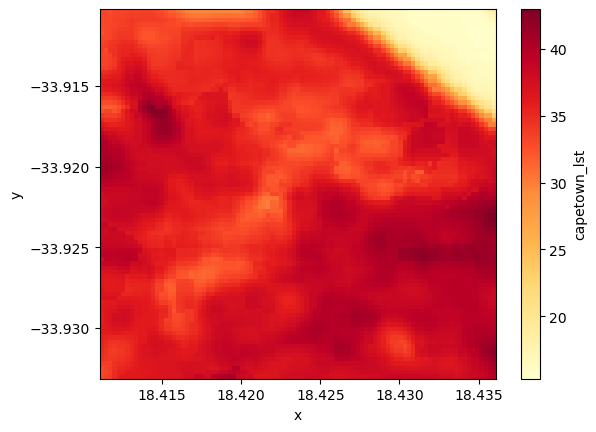

In [16]:
lst_ds['capetown_lst'].plot(cmap = "YlOrRd") # add the band name to be visualised

<Axes: title={'center': 'MRT'}, ylabel='Frequency'>

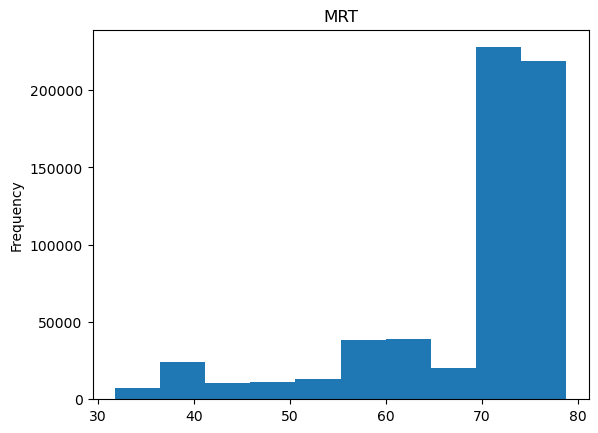

In [17]:
# making histogram
vec_df['capetown_tmrt'].plot(kind='hist', title = 'MRT')

<Axes: title={'center': 'LST'}, ylabel='Frequency'>

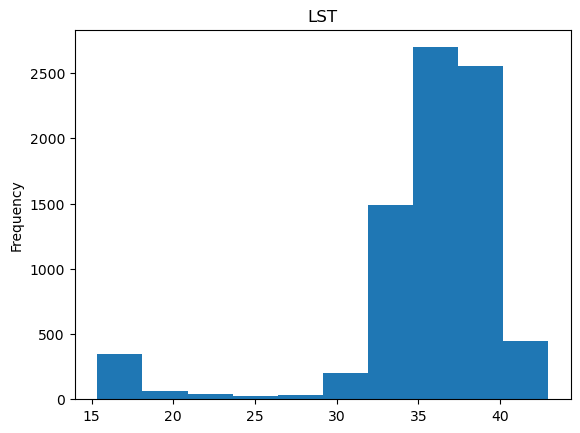

In [18]:
# making histogram
lst_df['capetown_lst'].plot(kind='hist', title = 'LST')

<Axes: title={'center': 'MRT'}, ylabel='Density'>

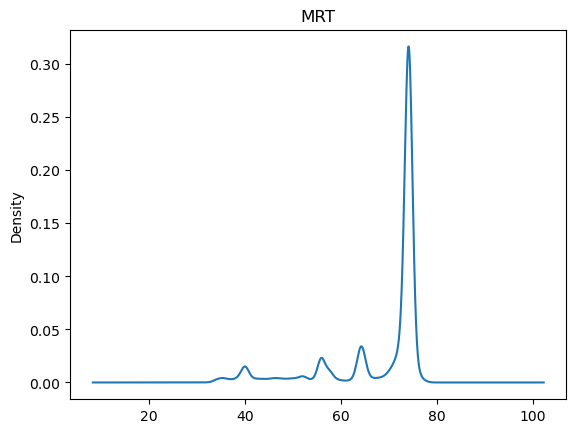

In [19]:
vec_df['capetown_tmrt'].plot(kind='density', title = 'MRT')

<Axes: title={'center': 'LST'}, ylabel='Density'>

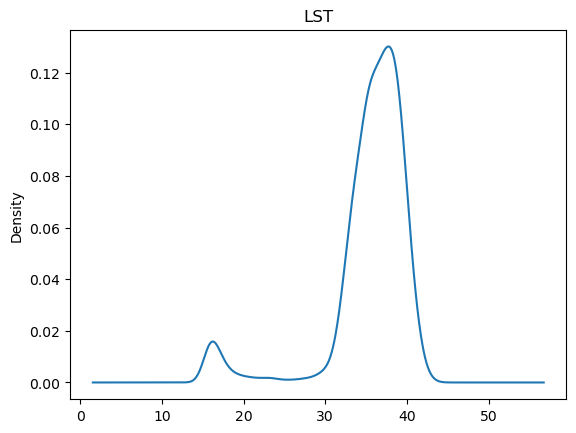

In [20]:
lst_df['capetown_lst'].plot(kind='density', title = 'LST')

In [21]:
vec_ss = calculate_zonalstats('constant', 'capetown_tmrt', xr_ds = vec_ds)
vec_ss # summary statistics of MRT | pass 'constant' as zone to get summary statistics

values                                                                \
          count       mean        std        min       25%       50%      75%   
zones                                                                           
0.0    609260.0  68.692642  10.098657  31.805239  65.52721  73.84856  74.2696   

                  
             max  
zones             
0.0    78.789055

In [22]:
lst_ss = calculate_zonalstats('constant', 'capetown_lst', xr_ds = lst_ds)
lst_ss # summary statistics of LST | pass 'constant' as zone to get summary statistics

values                                                        \
        count       mean       std        min        25%        50%   
zones                                                                 
0.0    7905.0  35.445775  5.149333  15.345473  34.339885  36.529696   

                             
             75%        max  
zones                        
0.0    38.408468  42.950731

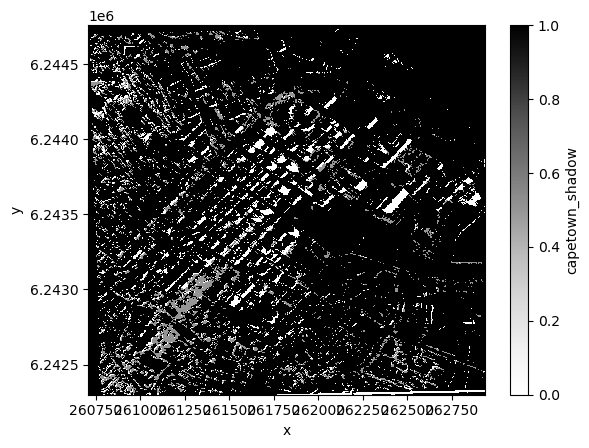

In [23]:
vec_ds['capetown_shadow'].plot(cmap = "Greys") # add the band name to be visualised

<Axes: title={'center': 'Shadow'}, ylabel='Frequency'>

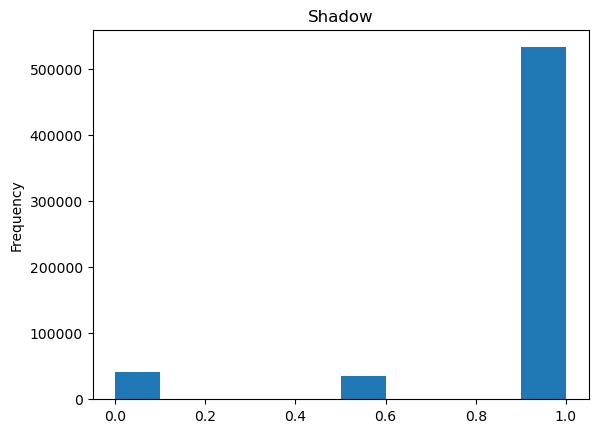

In [24]:
vec_df['capetown_shadow'].plot(kind='hist', title = 'Shadow')

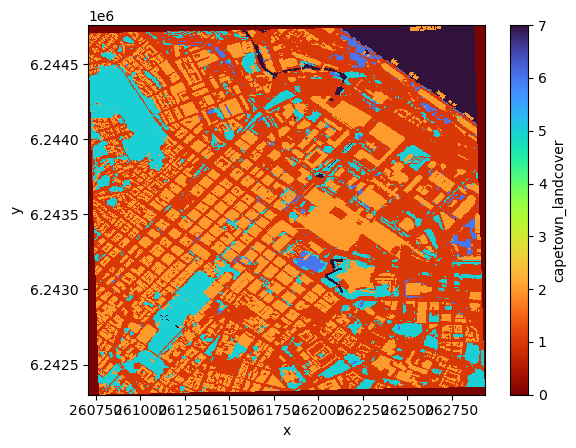

In [25]:
vec_ds['capetown_landcover'].plot(cmap = "turbo_r") # add the band name to be visualised

<Axes: title={'center': 'Land Cover'}, ylabel='Frequency'>

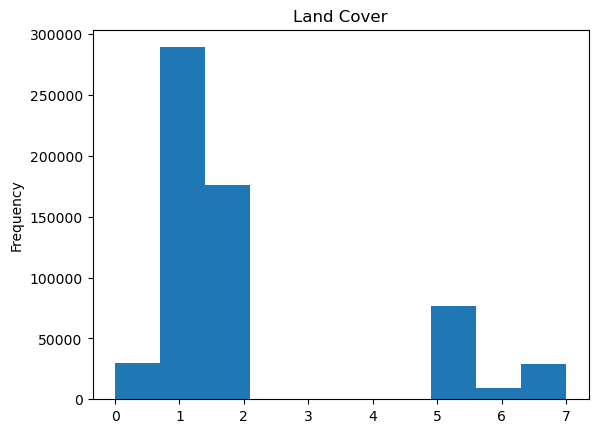

In [26]:
vec_df['capetown_landcover'].plot(kind='hist', title = 'Land Cover')

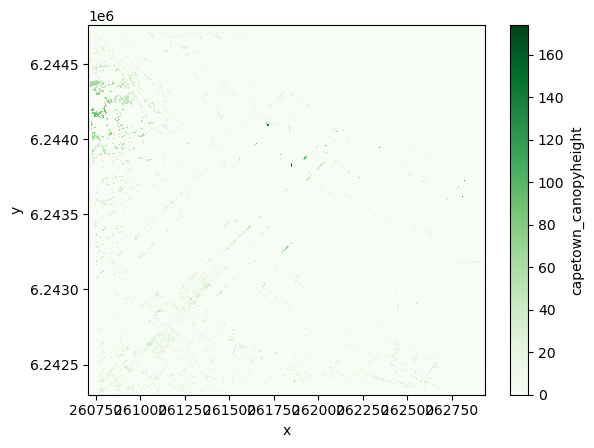

In [27]:
vec_ds['capetown_canopyheight'].plot(cmap = "Greens")

<Axes: title={'center': 'Canopy Height'}, ylabel='Frequency'>

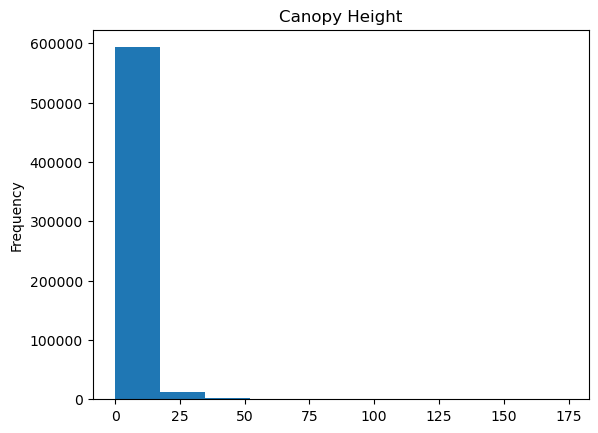

In [28]:
vec_df['capetown_canopyheight'].plot(kind='hist', title = 'Canopy Height')

<Axes: title={'center': 'Canopy Height'}, ylabel='Density'>

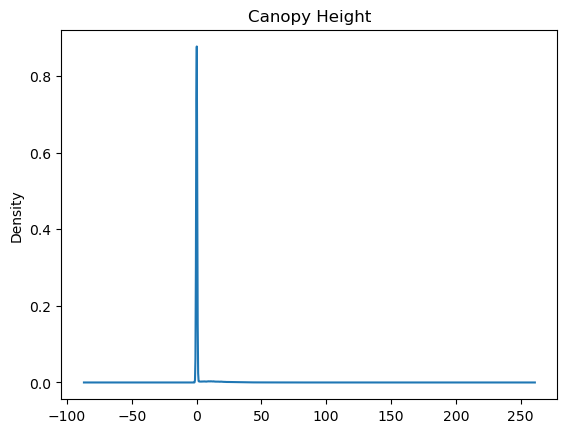

In [29]:
vec_df['capetown_canopyheight'].plot(kind='density', title = 'Canopy Height')

# Box Plots and Zonal Statistics

Text(0, 0.5, 'MRT')

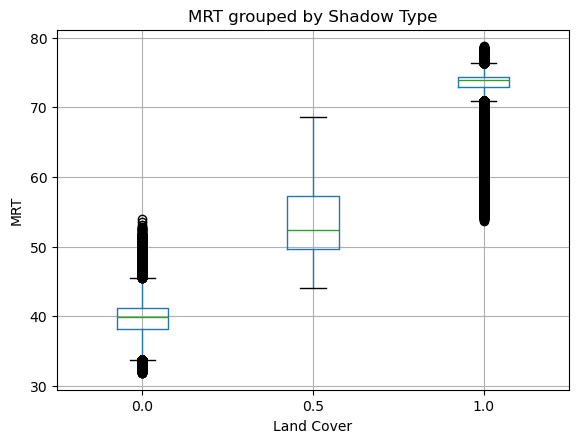

In [30]:
vec_df[['capetown_tmrt', 'capetown_shadow']].boxplot(by='capetown_shadow').get_figure().suptitle('')
plt.title('MRT grouped by Shadow Type')
plt.xlabel('Land Cover')
plt.ylabel('MRT')

In [31]:
calculate_zonalstats('capetown_shadow', 'capetown_tmrt', xr_ds = vec_ds) # zonal stats of MRT vs shadow types

values                                                        \
          count       mean       std        min        25%        50%   
zones                                                                   
0.0     41276.0  39.789616  3.076353  31.805239  38.196352  39.967234   
0.5     35393.0  53.115971  4.405599  44.103008  49.599220  52.456760   
1.0    532591.0  71.967773  4.800749  53.727421  72.931507  73.959450   

                             
             75%        max  
zones                        
0.0    41.141929  54.029556  
0.5    57.328228  68.555618  
1.0    74.321495  78.789055

Text(0, 0.5, 'MRT')

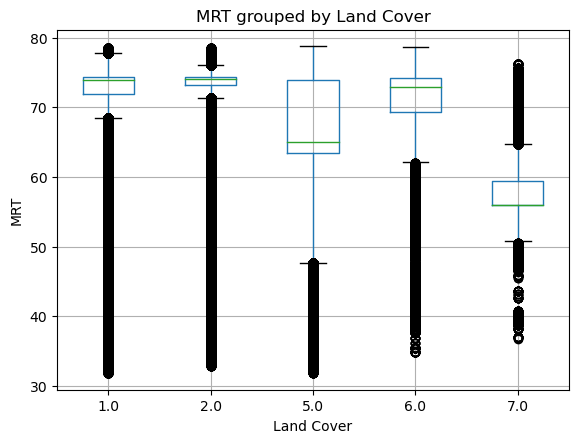

In [32]:
ras_df[['capetown_tmrt', 'citycentre_landcover']].boxplot(by='citycentre_landcover').get_figure().suptitle('')
plt.title('MRT grouped by Land Cover')
plt.xlabel('Land Cover')
plt.ylabel('MRT')

In [33]:
calculate_zonalstats('citycentre_landcover', 'capetown_tmrt', xr_ds = ras_ds) # zonal stats of MRT vs landcover at 1m

values                                                         \
           count       mean        std        min        25%        50%   
zones                                                                     
1.0    3007589.0  69.799530   9.502492  31.831116  71.949776  73.896561   
2.0    1838832.0  69.800850   9.954108  32.837635  73.158401  74.008286   
5.0     772343.0  64.742805  11.200793  31.805239  63.439735  65.091141   
6.0     102067.0  69.030434   8.735618  34.873539  69.350609  72.947113   
7.0     275373.0  60.158707   7.418181  36.667393  55.936981  56.018360   

                             
             75%        max  
zones                        
1.0    74.288712  78.559647  
2.0    74.335030  78.529526  
5.0    73.922409  78.789055  
6.0    74.147377  78.689812  
7.0    59.454266  76.230202

Text(0, 0.5, 'MRT')

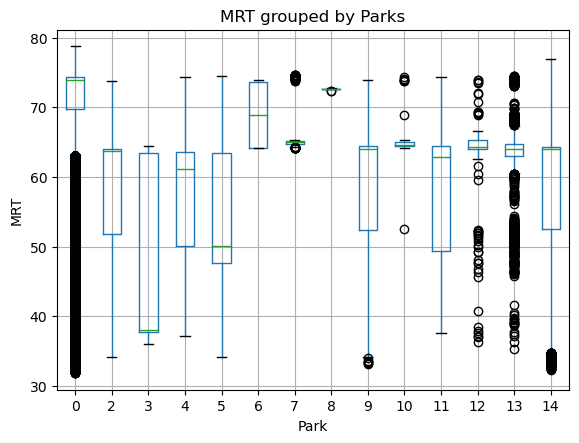

In [34]:
vec_df[['capetown_tmrt', 'capetown_parks']].boxplot(by='capetown_parks').get_figure().suptitle('')
plt.title('MRT grouped by Parks')
plt.xlabel('Park') # 0 in xaxis is for places without any park
plt.ylabel('MRT')

In [35]:
calculate_zonalstats('capetown_parks', 'capetown_tmrt', xr_ds = vec_ds) # zonal stats of MRT vs all parks

values                                                         \
          count       mean        std        min        25%        50%   
zones                                                                    
0      591532.0  68.970642   9.967419  31.805239  69.780922  73.874016   
2         389.0  58.084888   9.404024  34.148853  51.861515  63.674995   
3          28.0  45.580261  12.032931  36.013779  37.776115  37.989635   
4         309.0  57.236271   8.693503  37.166950  50.106400  61.162952   
5         882.0  53.992508   8.674617  34.217190  47.687783  50.028919   
6           4.0  68.945183   5.507034  64.155838  64.189100  68.857796   
7        1064.0  66.273529   3.365359  64.122993  64.786486  65.028912   
8           8.0  72.601273   0.186073  72.271446  72.594038  72.679619   
9        1086.0  58.958572   9.527105  33.180008  52.329759  64.076767   
10        110.0  65.100739   2.481190  52.595581  64.422657  64.593334   
11        354.0  57.944447   7.886018  37.592205  49.375544  62.894232   
12        257.0  63.082813   6.065497  36.302246  63.963577  64.328896   
13       1839.0  63.671059   7.325715  35.243736  63.044367  63.987831   
14      11398.0  58.588207  10.644211  32.326199  52.507960  64.030849   

                             
             75%        max  
zones                        
0      74.281206  78.789055  
2      64.074242  73.749374  
3      63.501697  64.426521  
4      63.542610  74.303749  
5      63.425938  74.562096  
6      73.613880  73.909309  
7      65.152473  74.633835  
8      72.694174  72.745117  
9      64.508608  73.985229  
10     65.011366  74.308983  
11     64.389824  74.386078  
12     65.342697  73.882042  
13     64.751766  74.464142  
14     64.323990  76.881195

Text(0, 0.5, 'MRT')

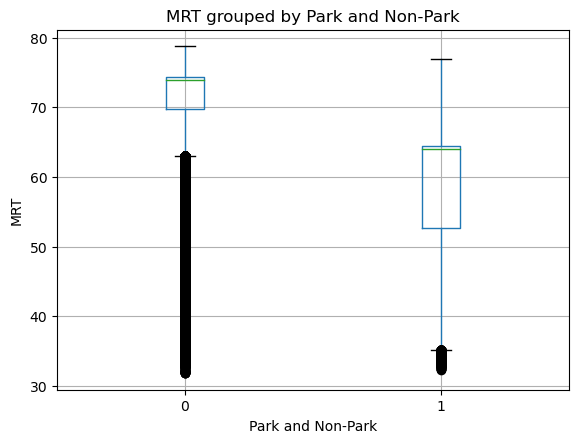

In [36]:
vec_df[['capetown_tmrt', 'capetown_parkdissolved']].boxplot(by='capetown_parkdissolved').get_figure().suptitle('')
plt.title('MRT grouped by Park and Non-Park')
plt.xlabel('Park and Non-Park') # 0 in xaxis is for places without any park
plt.ylabel('MRT')

In [37]:
calculate_zonalstats('capetown_parkdissolved', 'capetown_tmrt', xr_ds = vec_ds) # zonal stats of MRT vs parks dissolved

values                                                         \
          count       mean        std        min        25%        50%   
zones                                                                    
0      591532.0  68.970642   9.967419  31.805239  69.780922  73.874016   
1       17728.0  59.416996  10.061911  32.326199  52.714024  64.042076   

                             
             75%        max  
zones                        
0      74.281206  78.789055  
1      64.417217  76.881195